# Draft

A jupyter notebook to test various small tasks. Each section can be run separately.

## Reading video from opencv

In [85]:
# importing opencv
import cv2

In [86]:
# testing reading video from opencv
cap = cv2.VideoCapture(0)

while cap.isOpened():
    # capture frame
    ret, frame = cap.read()
    
    # display frame
    cv2.imshow("Testing camera", frame)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
    
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()

## Mediapipe hand landmarks detection on still image

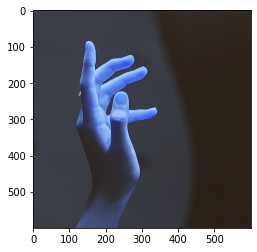

In [87]:
# Importing a test image
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/Hand_Model.jpg')
plt.imshow(img);

In [88]:
# Importing mediapipe modules
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [89]:
# creating a HandLandmarker object
base_options = python.BaseOptions(model_asset_path='./models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

In [90]:
# loading input image
image = mp.Image.create_from_file("./data/Hand_Model.jpg")

In [91]:
# detect landmarks from image
detection_result = detector.detect(image)

In [92]:
#Implementing a function to visualize the hand landmark detection results (from mediapipe guide)

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

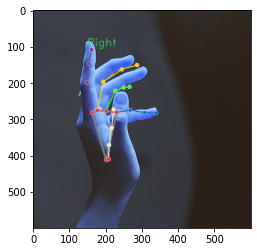

In [93]:
# Vizualize classification result
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

## Mediapipe hand landmarks detection on live video

Using detection + tracking

In [94]:
# importing opencv
import cv2

# importing mediapipe modules
import mediapipe as mp
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [95]:
# utility functions for inside the loop

def process_frame(frame, model):
    # convert frame to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # detect landmarks from image
    results = model.process(rgb_frame)
    return(results)

def annotate_frame(frame, results):
    if results.multi_hand_landmarks:
          for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

In [96]:
with mp_hands.Hands(max_num_hands = 2, min_detection_confidence = 0.5, min_tracking_confidence = 0.8) as hands:
    cap = cv2.VideoCapture(0)
    
    # setting up window size
    cv2.namedWindow("Annotated hands", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Annotated hands", 1000, 1000)
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # detect landmarks from image
        results = process_frame(frame, hands)
        
        # annotate the frame with landmarks
        annotate_frame(frame, results)
        
        # display frame
        cv2.imshow("Annotated hands", cv2.flip(frame, 1))
        
        # aiming for 25 fps
        if cv2.waitKey(40) & 0xFF == ord('q'):
            break
    
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()
        

## Saving landmarks

Hand detection + saving landmarks into a text file.

In [1]:
# importing opencv
import cv2

# importing numpy
import numpy as np

# importing mediapipe modules
import mediapipe as mp
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [5]:
# utility functions for inside the loop

def process_frame(frame, model):
    # convert frame to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # detect landmarks from image
    results = model.process(rgb_frame)
    return(results)

def annotate_frame(frame, results):
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing_styles.get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())
    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())
    
def landmarks_to_array(results):
    out_array = np.concatenate(
            (np.array([(lm.x, lm.y, lm.z, lm.visibility) for lm in results.pose_landmarks.landmark[7:17]]
                if results.pose_landmarks
                    else np.zeros(40)).flatten(),
            np.array([(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]
                if results.left_hand_landmarks
                 else np.zeros(63)).flatten(),
            np.array([(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]
                if results.right_hand_landmarks
                 else np.zeros(63)).flatten())
    )
    return(out_array)

In [41]:
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.8) as hands:
    cap = cv2.VideoCapture(0)
    
    # setting up window size
    cv2.namedWindow("Annotated hands", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Annotated hands", 1000, 1000)
    n_frame = 1
    
    # setting up the np array 
    all_landmarks = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # detect landmarks from image
        results = process_frame(frame, hands)
        
        # annotate the frame with landmarks
        annotate_frame(frame, results)
        
        # display frame
        cv2.imshow("Annotated hands", cv2.flip(frame, 1))
        
        # wait 40 ms or break if 'q' is pressed
        if cv2.waitKey(40) & 0xFF == ord('q'):
            break
            
        # alternatively, break if we reach 75 frames
        #if n_frame > 75:
        #    break
        n_frame = n_frame + 1
    
        landmarks = landmarks_to_array(results)
        try:
            all_landmarks = np.vstack([all_landmarks, landmarks])
        except:
            all_landmarks = landmarks
        
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()

np.save('all_landmarks.npy', all_landmarks)

In [46]:
loaded_all_landmarks = np.load('all_landmarks.npy')

In [47]:
loaded_all_landmarks

array([[ 0.63000405,  0.35943139, -0.61845803, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62988579,  0.35996452, -0.73263323, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62958002,  0.36115393, -0.74827659, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63185197,  0.38689554, -0.64050257, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63175112,  0.3868168 , -0.64150596, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63131285,  0.38667473, -0.63447016, ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
loaded_all_landmarks.shape

(47, 166)

# Checking data properties

In [11]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
glosses_df = pd.read_csv('data/WSASL_100/WLASL_100.csv')
glosses_df.head()

,Unnamed: 0,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,gloss,file
0,0,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,69241.mp4
1,10,"[462, 44, 949, 720]",25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,book,07069.mp4
2,17,"[234, 17, 524, 414]",25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,book,07068.mp4
3,22,"[131, 26, 526, 480]",25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,book,07070.mp4
4,24,"[162, 54, 528, 400]",25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,book,07099.mp4


In [14]:
# extracting frame_numbers
glosses_df['n_frames'] = np.zeros(glosses_df.shape[0])
for file in glosses_df.file:
    cap = cv2.VideoCapture('data/WSASL_100/videos/' + file)
    n = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    glosses_df['n_frames'][glosses_df.file == file] = n
    cap.release()

75.0
30.0
68.0
86.0
87.0
41.0
77.0
44.0
70.0
93.0
46.0
89.0
81.0


/tmp/ipykernel_304600/1006848514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glosses_df['n_frames'][glosses_df.file == file] = n


43.0
91.0
105.0
41.0
49.0
49.0
60.0
30.0
88.0
101.0
72.0
107.0
81.0
43.0
57.0
43.0
53.0
45.0
40.0
102.0
73.0
46.0
26.0
90.0
100.0
52.0
31.0
58.0
45.0
86.0
108.0
81.0
87.0
52.0
50.0
31.0
28.0
50.0
96.0
93.0
81.0
31.0
92.0
59.0
32.0
67.0
61.0
46.0
66.0
47.0
47.0
43.0
41.0
108.0
61.0
33.0
63.0
88.0
34.0
61.0
89.0
83.0
93.0
36.0
67.0
63.0
86.0
67.0
36.0
40.0
47.0
61.0
93.0
58.0
155.0
54.0
111.0
46.0
47.0
82.0
88.0
32.0
30.0
86.0
75.0
58.0
59.0
28.0
62.0
64.0
94.0
42.0
70.0
79.0
70.0
71.0
71.0
94.0
96.0
106.0
131.0
106.0
59.0
43.0
40.0
72.0
108.0
82.0
24.0
38.0
26.0
38.0
52.0
62.0
66.0
45.0
42.0
65.0
75.0
77.0
79.0
77.0
84.0
90.0
38.0
32.0
75.0
77.0
71.0
58.0
68.0
59.0
59.0
50.0
53.0
59.0
62.0
30.0
55.0
64.0
67.0
65.0
83.0
46.0
107.0
53.0
45.0
54.0
68.0
80.0
53.0
54.0
54.0
90.0
87.0
90.0
29.0
31.0
62.0
37.0
30.0
30.0
73.0
72.0
90.0
119.0
49.0
96.0
87.0
29.0
34.0
81.0
53.0
66.0
94.0
72.0
64.0
44.0
51.0
94.0
79.0
52.0
53.0
97.0
58.0
70.0
28.0
60.0
72.0
68.0
56.0
56.0
48.0
54.0
47.0
63.0
90.0


<AxesSubplot:xlabel='n_frames', ylabel='Count'>

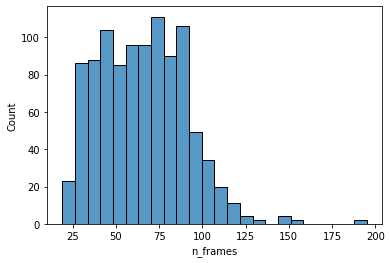

In [18]:
sns.histplot(glosses_df, x = 'n_frames')

<AxesSubplot:xlabel='gloss'>

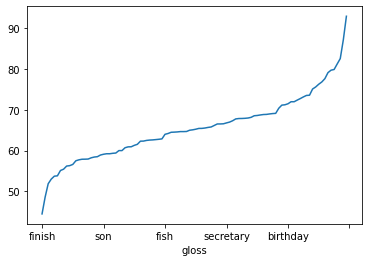

In [23]:
glosses_df.groupby('gloss').agg(np.mean)['n_frames'].sort_values().plot()

In [24]:
glosses_df.groupby('gloss').agg(np.mean)['n_frames']

gloss
accident      66.538462
africa        72.777778
all           79.750000
apple         81.272727
basketball    67.333333
                ...    
woman         60.000000
work          65.800000
wrong         58.500000
year          64.200000
yes           58.416667
Name: n_frames, Length: 100, dtype: float64

In [44]:
glosses_df[glosses_df.gloss == 'black']

,Unnamed: 0,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,gloss,file,n_frames
221,479,"[295, 38, 885, 720]",25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/black.mp4,0,69236,black,69236.mp4,63.0
222,482,"[205, 17, 524, 414]",25,-1,1,4,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,6472,black,06472.mp4,91.0
223,483,"[544, 60, 1618, 1080]",25,-1,1,5,4,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,6473,black,06473.mp4,56.0
224,484,"[77, 18, 515, 480]",25,-1,1,6,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,6474,black,06474.mp4,80.0
225,486,"[58, 15, 216, 192]",25,-1,1,8,11,signingsavvy,val,https://www.signingsavvy.com/signs/mp4/6/6787.mp4,0,6476,black,06476.mp4,33.0
226,487,"[48, 11, 226, 192]",25,-1,1,9,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/7/7145.mp4,0,6477,black,06477.mp4,24.0
227,488,"[63, 8, 245, 192]",25,-1,1,10,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/8/8384.mp4,0,6478,black,06478.mp4,45.0
228,490,"[149, 24, 479, 370]",25,-1,1,13,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65200,black,65200.mp4,47.0
229,491,"[66, 13, 258, 240]",25,-1,1,14,56,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,6471,black,06471.mp4,77.0
230,498,"[131, 52, 555, 400]",25,-1,1,21,12,aslsearch,train,http://www.aslsearch.com/signs/videos/black.mp4,0,6486,black,06486.mp4,111.0


# Testing ML on 5 glosses

In [486]:
import numpy as np
import tensorflow as tf
import keras
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [487]:
## load npy_data:
features = []
labels = []
data_path = 'data/WSASL_100/landmarks_5/'
folders_list = os.listdir(data_path)
for folder in folders_list:
    files = os.listdir(data_path + folder)
    for file in files:
        features.append(np.load(data_path + folder + '/' + file))
        labels.append(folder)

In [488]:
# mapping labels to ints:
labels_map = {label:number for number, label in enumerate(np.unique(labels))}
mapped_labels = [labels_map[lab] for lab in labels]
mapped_labels = np.array(mapped_labels)
mapped_labels = to_categorical(mapped_labels).astype(int)

In [489]:
## padding features:
padded_features = keras.utils.pad_sequences(features, maxlen=100)
padded_features = np.array(padded_features)

In [490]:
X_train, X_test, y_train, y_test = train_test_split(padded_features,
                                                    mapped_labels,
                                                    test_size = 0.1)

In [491]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [492]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(100,166)))
model.add(LSTM(16, return_sequences=False, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

In [493]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 100, 16)           11712     
                                                                 
 lstm_70 (LSTM)              (None, 16)                2112      
                                                                 
 dense_78 (Dense)            (None, 16)                272       
                                                                 
 dense_79 (Dense)            (None, 5)                 85        
                                                                 
Total params: 14181 (55.39 KB)
Trainable params: 14181 (55.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [494]:
initial_learning_rate = 10**-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.96,
    staircase=True)

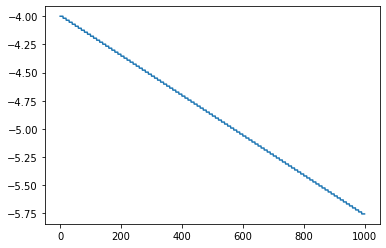

In [495]:
epoch = [i for i in range(1000)]
lr = [lr_schedule(ep) for ep in epoch]
plt.plot(epoch, np.log10(lr))

In [496]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [497]:
history = model.fit(padded_features, mapped_labels, epochs=1000, validation_split=0.1)

Epoch 1/1000
2/2 [==============================] - 2s 334ms/step - loss: 1.6094 - categorical_accuracy: 0.2200 - val_loss: 1.6219 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.6091 - categorical_accuracy: 0.2400 - val_loss: 1.6228 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.6088 - categorical_accuracy: 0.2400 - val_loss: 1.6236 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.6086 - categorical_accuracy: 0.2400 - val_loss: 1.6244 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.6083 - categorical_accuracy: 0.2400 - val_loss: 1.6252 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
2/2 [==============================] - 0s 63ms/step - loss: 1.6080 - categorical_accuracy: 0.2400 - val_loss: 1.6259 - val_categorical_accura

2/2 [==============================] - 0s 81ms/step - loss: 1.6003 - categorical_accuracy: 0.2400 - val_loss: 1.6508 - val_categorical_accuracy: 0.0000e+00
Epoch 50/1000
2/2 [==============================] - 0s 82ms/step - loss: 1.6002 - categorical_accuracy: 0.2400 - val_loss: 1.6513 - val_categorical_accuracy: 0.0000e+00
Epoch 51/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.6000 - categorical_accuracy: 0.2600 - val_loss: 1.6517 - val_categorical_accuracy: 0.0000e+00
Epoch 52/1000
2/2 [==============================] - 0s 75ms/step - loss: 1.5999 - categorical_accuracy: 0.2600 - val_loss: 1.6521 - val_categorical_accuracy: 0.0000e+00
Epoch 53/1000
2/2 [==============================] - 0s 79ms/step - loss: 1.5998 - categorical_accuracy: 0.2600 - val_loss: 1.6525 - val_categorical_accuracy: 0.0000e+00
Epoch 54/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5996 - categorical_accuracy: 0.2600 - val_loss: 1.6530 - val_categorical_accuracy: 0.000

2/2 [==============================] - 0s 70ms/step - loss: 1.5940 - categorical_accuracy: 0.2800 - val_loss: 1.6714 - val_categorical_accuracy: 0.0000e+00
Epoch 98/1000
2/2 [==============================] - 0s 71ms/step - loss: 1.5939 - categorical_accuracy: 0.2800 - val_loss: 1.6718 - val_categorical_accuracy: 0.0000e+00
Epoch 99/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5938 - categorical_accuracy: 0.2800 - val_loss: 1.6722 - val_categorical_accuracy: 0.0000e+00
Epoch 100/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.5937 - categorical_accuracy: 0.2800 - val_loss: 1.6727 - val_categorical_accuracy: 0.0000e+00
Epoch 101/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5935 - categorical_accuracy: 0.2800 - val_loss: 1.6731 - val_categorical_accuracy: 0.0000e+00
Epoch 102/1000
2/2 [==============================] - 0s 118ms/step - loss: 1.5934 - categorical_accuracy: 0.2800 - val_loss: 1.6734 - val_categorical_accuracy: 0

Epoch 145/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.5885 - categorical_accuracy: 0.2400 - val_loss: 1.6887 - val_categorical_accuracy: 0.0000e+00
Epoch 146/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.5883 - categorical_accuracy: 0.2400 - val_loss: 1.6890 - val_categorical_accuracy: 0.0000e+00
Epoch 147/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.5883 - categorical_accuracy: 0.2400 - val_loss: 1.6894 - val_categorical_accuracy: 0.0000e+00
Epoch 148/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.5881 - categorical_accuracy: 0.2400 - val_loss: 1.6897 - val_categorical_accuracy: 0.0000e+00
Epoch 149/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.5880 - categorical_accuracy: 0.2400 - val_loss: 1.6900 - val_categorical_accuracy: 0.0000e+00
Epoch 150/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.5879 - categorical_accuracy: 0.2400 - val_loss: 1.6903 - val_categor

Epoch 193/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.5835 - categorical_accuracy: 0.2600 - val_loss: 1.7021 - val_categorical_accuracy: 0.0000e+00
Epoch 194/1000
2/2 [==============================] - 0s 64ms/step - loss: 1.5834 - categorical_accuracy: 0.2600 - val_loss: 1.7024 - val_categorical_accuracy: 0.0000e+00
Epoch 195/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5833 - categorical_accuracy: 0.2600 - val_loss: 1.7026 - val_categorical_accuracy: 0.0000e+00
Epoch 196/1000
2/2 [==============================] - 0s 71ms/step - loss: 1.5832 - categorical_accuracy: 0.2600 - val_loss: 1.7028 - val_categorical_accuracy: 0.0000e+00
Epoch 197/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5832 - categorical_accuracy: 0.2600 - val_loss: 1.7031 - val_categorical_accuracy: 0.0000e+00
Epoch 198/1000
2/2 [==============================] - 0s 64ms/step - loss: 1.5831 - categorical_accuracy: 0.2600 - val_loss: 1.7033 - val_categor

Epoch 241/1000
2/2 [==============================] - 0s 182ms/step - loss: 1.5795 - categorical_accuracy: 0.2800 - val_loss: 1.7127 - val_categorical_accuracy: 0.0000e+00
Epoch 242/1000
2/2 [==============================] - 0s 102ms/step - loss: 1.5794 - categorical_accuracy: 0.2800 - val_loss: 1.7129 - val_categorical_accuracy: 0.0000e+00
Epoch 243/1000
2/2 [==============================] - 0s 127ms/step - loss: 1.5794 - categorical_accuracy: 0.2800 - val_loss: 1.7131 - val_categorical_accuracy: 0.0000e+00
Epoch 244/1000
2/2 [==============================] - 0s 130ms/step - loss: 1.5793 - categorical_accuracy: 0.2800 - val_loss: 1.7133 - val_categorical_accuracy: 0.0000e+00
Epoch 245/1000
2/2 [==============================] - 0s 98ms/step - loss: 1.5792 - categorical_accuracy: 0.2800 - val_loss: 1.7135 - val_categorical_accuracy: 0.0000e+00
Epoch 246/1000
2/2 [==============================] - 0s 125ms/step - loss: 1.5791 - categorical_accuracy: 0.2800 - val_loss: 1.7137 - val_ca

Epoch 289/1000
2/2 [==============================] - 0s 79ms/step - loss: 1.5764 - categorical_accuracy: 0.3000 - val_loss: 1.7208 - val_categorical_accuracy: 0.0000e+00
Epoch 290/1000
2/2 [==============================] - 0s 83ms/step - loss: 1.5763 - categorical_accuracy: 0.3000 - val_loss: 1.7209 - val_categorical_accuracy: 0.0000e+00
Epoch 291/1000
2/2 [==============================] - 0s 71ms/step - loss: 1.5762 - categorical_accuracy: 0.3000 - val_loss: 1.7210 - val_categorical_accuracy: 0.0000e+00
Epoch 292/1000
2/2 [==============================] - 0s 82ms/step - loss: 1.5762 - categorical_accuracy: 0.3000 - val_loss: 1.7212 - val_categorical_accuracy: 0.0000e+00
Epoch 293/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5761 - categorical_accuracy: 0.3000 - val_loss: 1.7213 - val_categorical_accuracy: 0.0000e+00
Epoch 294/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5761 - categorical_accuracy: 0.3000 - val_loss: 1.7214 - val_categor

Epoch 337/1000
2/2 [==============================] - 0s 88ms/step - loss: 1.5740 - categorical_accuracy: 0.3000 - val_loss: 1.7266 - val_categorical_accuracy: 0.0000e+00
Epoch 338/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5739 - categorical_accuracy: 0.3000 - val_loss: 1.7267 - val_categorical_accuracy: 0.0000e+00
Epoch 339/1000
2/2 [==============================] - 0s 75ms/step - loss: 1.5739 - categorical_accuracy: 0.3000 - val_loss: 1.7268 - val_categorical_accuracy: 0.0000e+00
Epoch 340/1000
2/2 [==============================] - 0s 74ms/step - loss: 1.5738 - categorical_accuracy: 0.3000 - val_loss: 1.7269 - val_categorical_accuracy: 0.0000e+00
Epoch 341/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5738 - categorical_accuracy: 0.3000 - val_loss: 1.7270 - val_categorical_accuracy: 0.0000e+00
Epoch 342/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5737 - categorical_accuracy: 0.3000 - val_loss: 1.7270 - val_categor

Epoch 385/1000
2/2 [==============================] - 0s 62ms/step - loss: 1.5722 - categorical_accuracy: 0.3000 - val_loss: 1.7308 - val_categorical_accuracy: 0.0000e+00
Epoch 386/1000
2/2 [==============================] - 0s 64ms/step - loss: 1.5722 - categorical_accuracy: 0.3000 - val_loss: 1.7309 - val_categorical_accuracy: 0.0000e+00
Epoch 387/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5722 - categorical_accuracy: 0.3000 - val_loss: 1.7309 - val_categorical_accuracy: 0.0000e+00
Epoch 388/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.5721 - categorical_accuracy: 0.3000 - val_loss: 1.7310 - val_categorical_accuracy: 0.0000e+00
Epoch 389/1000
2/2 [==============================] - 0s 74ms/step - loss: 1.5721 - categorical_accuracy: 0.3000 - val_loss: 1.7311 - val_categorical_accuracy: 0.0000e+00
Epoch 390/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.5721 - categorical_accuracy: 0.3000 - val_loss: 1.7311 - val_categor

Epoch 433/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5711 - categorical_accuracy: 0.3000 - val_loss: 1.7337 - val_categorical_accuracy: 0.0000e+00
Epoch 434/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5710 - categorical_accuracy: 0.3000 - val_loss: 1.7338 - val_categorical_accuracy: 0.0000e+00
Epoch 435/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5710 - categorical_accuracy: 0.3000 - val_loss: 1.7338 - val_categorical_accuracy: 0.0000e+00
Epoch 436/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5710 - categorical_accuracy: 0.3000 - val_loss: 1.7339 - val_categorical_accuracy: 0.0000e+00
Epoch 437/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.5710 - categorical_accuracy: 0.3000 - val_loss: 1.7339 - val_categorical_accuracy: 0.0000e+00
Epoch 438/1000
2/2 [==============================] - 0s 65ms/step - loss: 1.5710 - categorical_accuracy: 0.3000 - val_loss: 1.7340 - val_categor

Epoch 481/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5703 - categorical_accuracy: 0.3000 - val_loss: 1.7358 - val_categorical_accuracy: 0.0000e+00
Epoch 482/1000
2/2 [==============================] - 0s 78ms/step - loss: 1.5703 - categorical_accuracy: 0.3000 - val_loss: 1.7358 - val_categorical_accuracy: 0.0000e+00
Epoch 483/1000
2/2 [==============================] - 0s 65ms/step - loss: 1.5703 - categorical_accuracy: 0.3000 - val_loss: 1.7358 - val_categorical_accuracy: 0.0000e+00
Epoch 484/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5703 - categorical_accuracy: 0.3000 - val_loss: 1.7359 - val_categorical_accuracy: 0.0000e+00
Epoch 485/1000
2/2 [==============================] - 0s 85ms/step - loss: 1.5703 - categorical_accuracy: 0.3000 - val_loss: 1.7359 - val_categorical_accuracy: 0.0000e+00
Epoch 486/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5703 - categorical_accuracy: 0.3000 - val_loss: 1.7359 - val_categor

Epoch 529/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5698 - categorical_accuracy: 0.3000 - val_loss: 1.7371 - val_categorical_accuracy: 0.0000e+00
Epoch 530/1000
2/2 [==============================] - 0s 76ms/step - loss: 1.5698 - categorical_accuracy: 0.3000 - val_loss: 1.7371 - val_categorical_accuracy: 0.0000e+00
Epoch 531/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5698 - categorical_accuracy: 0.3000 - val_loss: 1.7372 - val_categorical_accuracy: 0.0000e+00
Epoch 532/1000
2/2 [==============================] - 0s 80ms/step - loss: 1.5698 - categorical_accuracy: 0.3000 - val_loss: 1.7372 - val_categorical_accuracy: 0.0000e+00
Epoch 533/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5698 - categorical_accuracy: 0.3000 - val_loss: 1.7372 - val_categorical_accuracy: 0.0000e+00
Epoch 534/1000
2/2 [==============================] - 0s 83ms/step - loss: 1.5698 - categorical_accuracy: 0.3000 - val_loss: 1.7372 - val_categor

Epoch 577/1000
2/2 [==============================] - 0s 79ms/step - loss: 1.5695 - categorical_accuracy: 0.3000 - val_loss: 1.7380 - val_categorical_accuracy: 0.0000e+00
Epoch 578/1000
2/2 [==============================] - 0s 79ms/step - loss: 1.5695 - categorical_accuracy: 0.3000 - val_loss: 1.7380 - val_categorical_accuracy: 0.0000e+00
Epoch 579/1000
2/2 [==============================] - 0s 83ms/step - loss: 1.5695 - categorical_accuracy: 0.3000 - val_loss: 1.7380 - val_categorical_accuracy: 0.0000e+00
Epoch 580/1000
2/2 [==============================] - 0s 81ms/step - loss: 1.5695 - categorical_accuracy: 0.3000 - val_loss: 1.7381 - val_categorical_accuracy: 0.0000e+00
Epoch 581/1000
2/2 [==============================] - 0s 80ms/step - loss: 1.5695 - categorical_accuracy: 0.3000 - val_loss: 1.7381 - val_categorical_accuracy: 0.0000e+00
Epoch 582/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5695 - categorical_accuracy: 0.3000 - val_loss: 1.7381 - val_categor

Epoch 625/1000
2/2 [==============================] - 0s 86ms/step - loss: 1.5692 - categorical_accuracy: 0.3000 - val_loss: 1.7386 - val_categorical_accuracy: 0.0000e+00
Epoch 626/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5692 - categorical_accuracy: 0.3000 - val_loss: 1.7387 - val_categorical_accuracy: 0.0000e+00
Epoch 627/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.5692 - categorical_accuracy: 0.3000 - val_loss: 1.7387 - val_categorical_accuracy: 0.0000e+00
Epoch 628/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.5692 - categorical_accuracy: 0.3000 - val_loss: 1.7387 - val_categorical_accuracy: 0.0000e+00
Epoch 629/1000
2/2 [==============================] - 0s 75ms/step - loss: 1.5692 - categorical_accuracy: 0.3000 - val_loss: 1.7387 - val_categorical_accuracy: 0.0000e+00
Epoch 630/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5692 - categorical_accuracy: 0.3000 - val_loss: 1.7387 - val_categor

Epoch 673/1000
2/2 [==============================] - 0s 75ms/step - loss: 1.5691 - categorical_accuracy: 0.3200 - val_loss: 1.7391 - val_categorical_accuracy: 0.0000e+00
Epoch 674/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5691 - categorical_accuracy: 0.3200 - val_loss: 1.7391 - val_categorical_accuracy: 0.0000e+00
Epoch 675/1000
2/2 [==============================] - 0s 74ms/step - loss: 1.5691 - categorical_accuracy: 0.3200 - val_loss: 1.7391 - val_categorical_accuracy: 0.0000e+00
Epoch 676/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5691 - categorical_accuracy: 0.3200 - val_loss: 1.7391 - val_categorical_accuracy: 0.0000e+00
Epoch 677/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5691 - categorical_accuracy: 0.3200 - val_loss: 1.7391 - val_categorical_accuracy: 0.0000e+00
Epoch 678/1000
2/2 [==============================] - 0s 71ms/step - loss: 1.5691 - categorical_accuracy: 0.3200 - val_loss: 1.7391 - val_categor

Epoch 721/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5690 - categorical_accuracy: 0.3200 - val_loss: 1.7393 - val_categorical_accuracy: 0.0000e+00
Epoch 722/1000
2/2 [==============================] - 0s 76ms/step - loss: 1.5690 - categorical_accuracy: 0.3200 - val_loss: 1.7393 - val_categorical_accuracy: 0.0000e+00
Epoch 723/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.5690 - categorical_accuracy: 0.3200 - val_loss: 1.7394 - val_categorical_accuracy: 0.0000e+00
Epoch 724/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.5690 - categorical_accuracy: 0.3200 - val_loss: 1.7394 - val_categorical_accuracy: 0.0000e+00
Epoch 725/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.5690 - categorical_accuracy: 0.3200 - val_loss: 1.7394 - val_categorical_accuracy: 0.0000e+00
Epoch 726/1000
2/2 [==============================] - 0s 74ms/step - loss: 1.5690 - categorical_accuracy: 0.3200 - val_loss: 1.7394 - val_categor

Epoch 769/1000
2/2 [==============================] - 0s 82ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7395 - val_categorical_accuracy: 0.0000e+00
Epoch 770/1000
2/2 [==============================] - 0s 73ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7395 - val_categorical_accuracy: 0.0000e+00
Epoch 771/1000
2/2 [==============================] - 0s 82ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7395 - val_categorical_accuracy: 0.0000e+00
Epoch 772/1000
2/2 [==============================] - 0s 80ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7395 - val_categorical_accuracy: 0.0000e+00
Epoch 773/1000
2/2 [==============================] - 0s 74ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7395 - val_categorical_accuracy: 0.0000e+00
Epoch 774/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7395 - val_categor

Epoch 817/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 818/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 819/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 820/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 821/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 822/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categor

Epoch 865/1000
2/2 [==============================] - 0s 78ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 866/1000
2/2 [==============================] - 0s 76ms/step - loss: 1.5689 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 867/1000
2/2 [==============================] - 0s 65ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 868/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 869/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categorical_accuracy: 0.0000e+00
Epoch 870/1000
2/2 [==============================] - 0s 67ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7397 - val_categor

Epoch 913/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 914/1000
2/2 [==============================] - 0s 69ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 915/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 916/1000
2/2 [==============================] - 0s 70ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 917/1000
2/2 [==============================] - 0s 66ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 918/1000
2/2 [==============================] - 0s 68ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categor

Epoch 961/1000
2/2 [==============================] - 0s 72ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 962/1000
2/2 [==============================] - 0s 78ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 963/1000
2/2 [==============================] - 0s 77ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 964/1000
2/2 [==============================] - 0s 78ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 965/1000
2/2 [==============================] - 0s 74ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categorical_accuracy: 0.0000e+00
Epoch 966/1000
2/2 [==============================] - 0s 84ms/step - loss: 1.5688 - categorical_accuracy: 0.3200 - val_loss: 1.7398 - val_categor

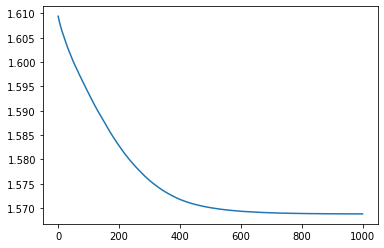

In [498]:
plt.plot(history.history['loss'])

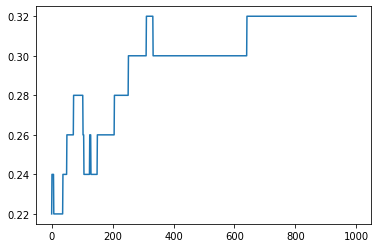

In [499]:
plt.plot(history.history['categorical_accuracy'])

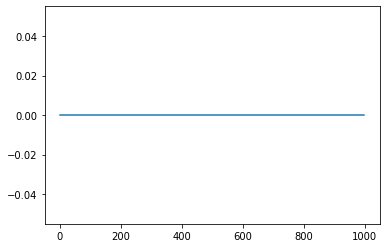

In [500]:
plt.plot(history.history['val_categorical_accuracy'])

In [501]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 100, 16)           11712     
                                                                 
 lstm_70 (LSTM)              (None, 16)                2112      
                                                                 
 dense_78 (Dense)            (None, 16)                272       
                                                                 
 dense_79 (Dense)            (None, 5)                 85        
                                                                 
Total params: 14181 (55.39 KB)
Trainable params: 14181 (55.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
